# Preprocessing data with ecv and nutritional metrics 

### Objective

The objective of this notebook is to preprocess the data through the following five steps:

1. Handling Missing Data
2. Exploratory Data Analysis (EDA)
3. Data Visualization and PCA
4. Outlier Detection
5. Bias Detection


In [60]:
import pandas as pd
import requests
from pathlib import Path
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pathlib import Path
import sys

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.utils import *

In [61]:
DATA_DIR = Path(project_root / "data")
RECIPES_FILE = DATA_DIR / "all_recipes_clean.json"

In [62]:
with open(RECIPES_FILE, "r", encoding="utf-8") as f:
    recipes = json.load(f)

df = pd.DataFrame(recipes)

## 1. Handling missing data 

In [63]:
col_missing = pd.DataFrame({
    "contain missing data": df.isna().sum() != 0,
    "missing_frequency": df.isna().mean() * 100
})
display(col_missing)

,contain missing data,missing_frequency
title,False,0.0
url,False,0.0
rating,False,0.0
ingredients,False,0.0
total_ecv,False,0.0
total_kcal,False,0.0
total_protein,False,0.0
total_fat,False,0.0
is_vege,False,0.0


## 2. Exploratory Data Analysis (EDA)

In [64]:
print("Shape (rows, cols):", df.shape)
print("Number of elements:", df.size)
print(df.dtypes)
print(df["ingredients"])

Shape (rows, cols): (2089, 9)
Number of elements: 18801
title             object
url               object
rating           float64
ingredients       object
total_ecv        float64
total_kcal       float64
total_protein    float64
total_fat        float64
is_vege            int64
dtype: object
0       [{'ingredient_name': 'tomates', 'quantity': 20...
1       [{'ingredient_name': 'poireau', 'quantity': 15...
2       [{'ingredient_name': 'carotte', 'quantity': 40...
3       [{'ingredient_name': 'oeuf', 'quantity': 60.0,...
4       [{'ingredient_name': 'beurre', 'quantity': 20....
                              ...                        
2084    [{'ingredient_name': 'carottes', 'quantity': 1...
2085    [{'ingredient_name': 'beurre', 'quantity': 100...
2086    [{'ingredient_name': 'beurre', 'quantity': 40....
2087    [{'ingredient_name': 'tomates', 'quantity': 20...
2088    [{'ingredient_name': 'carotte', 'quantity': 15...
Name: ingredients, Length: 2089, dtype: object


Nombre de recettes par catégorie

is_vege
0    1099
1     990
Name: count, dtype: int64


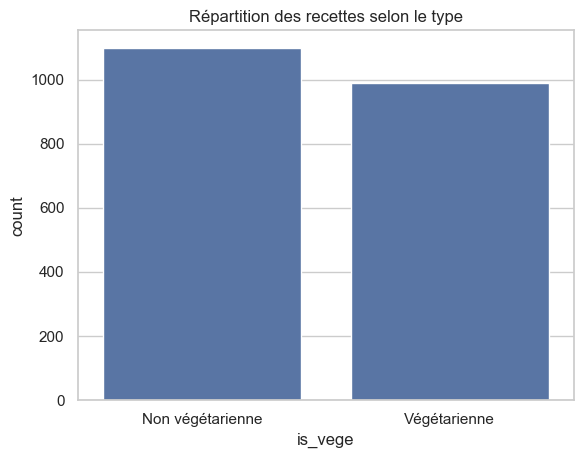

In [65]:
print(df["is_vege"].value_counts())
sns.countplot(x="is_vege", data=df)
plt.xticks([0,1], ["Non végétarienne", "Végétarienne"])
plt.title("Répartition des recettes selon le type")
plt.show()

Statistiques descriptives

In [66]:
display(df.describe())

,rating,total_ecv,total_kcal,total_protein,total_fat,is_vege
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,3.562087,4.642496,1307.109931,82.555216,87.370462,0.473911
std,1.827000,9.402856,1845.274577,114.354249,160.952798,0.499438
min,0.000000,0.013862,0.000000,0.000000,0.000000,0.000000
25%,3.300000,0.316533,298.136364,20.233056,14.480000,0.000000
50%,4.400000,1.368129,628.836364,41.333333,29.637273,0.000000
75%,4.800000,4.410986,1423.288889,100.902778,77.958333,1.000000
max,5.000000,95.785142,13396.533333,922.948377,1330.613333,1.000000


Distributions

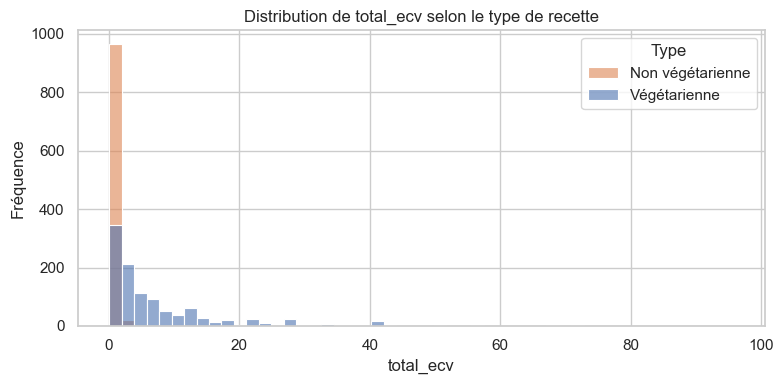

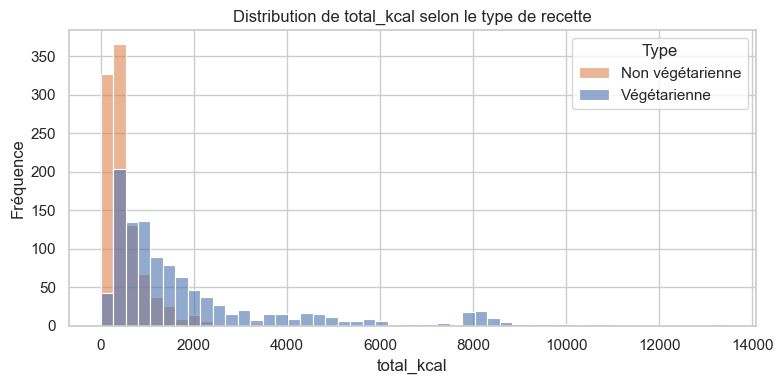

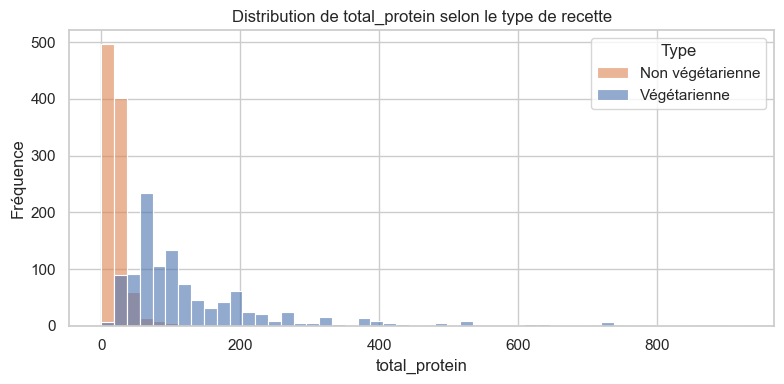

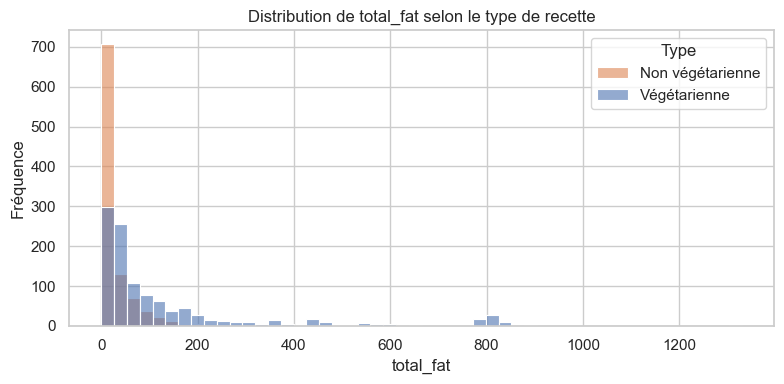

In [67]:
num_cols = ['total_ecv', 'total_kcal', 'total_protein', 'total_fat']

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=col, hue='is_vege', bins=50, alpha=0.6)
    plt.title(f"Distribution de {col} selon le type de recette")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.legend(title="Type", labels=["Non végétarienne", "Végétarienne"])
    plt.tight_layout()
    plt.show()

Comparaison de moyennes

/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/3168639301.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/3168639301.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non végé", "Végétarienne"])
/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/3168639301.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/3168639301.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ti

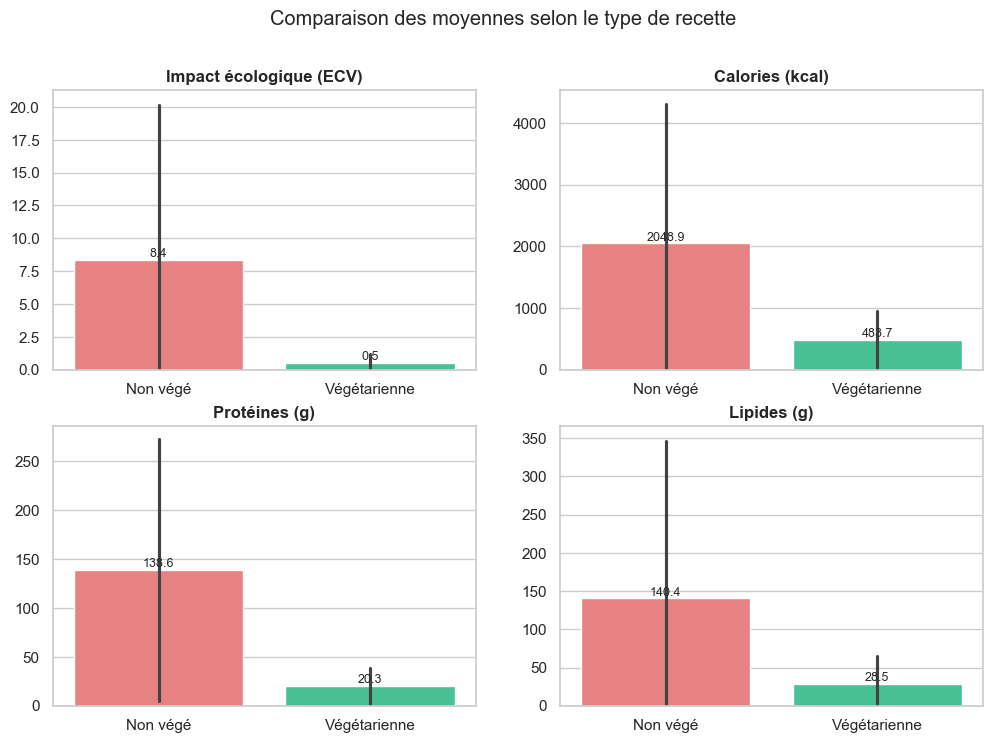

In [68]:

metrics = ['total_ecv', 'total_kcal', 'total_protein', 'total_fat']
labels = {
    'total_ecv': "Impact écologique (ECV)",
    'total_kcal': "Calories (kcal)",
    'total_protein': "Protéines (g)",
    'total_fat': "Lipides (g)"
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  
axes = axes.flatten()  # pour boucler facilement

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df,
        x='is_vege',
        y=metric,
        errorbar='sd',
        palette=['#F87171', '#34D399'],  # rouge (non vege) / vert (vege)
        ax=ax
    )
    ax.set_title(labels[metric], weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(["Non végé", "Végétarienne"])
    ax.set_ylim(bottom=0) 

    # Ajouter les valeurs moyennes sur les barres
    for p in ax.patches:
        value = p.get_height()
        ax.annotate(f"{value:.1f}",
                    (p.get_x() + p.get_width() / 2., value),
                    ha='center', va='bottom', fontsize=9)

plt.suptitle("Comparaison des moyennes selon le type de recette")
plt.show()

Correlations

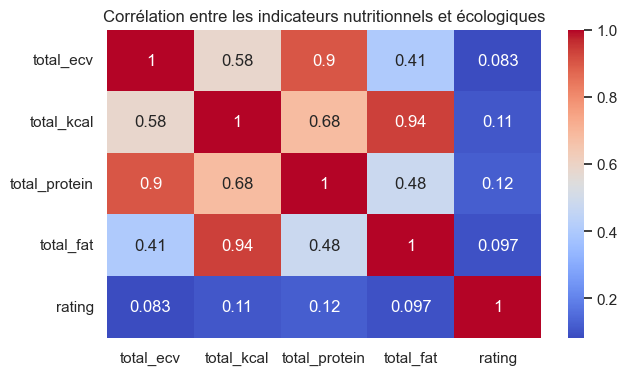

In [69]:
# Toutes recettes
plt.figure(figsize=(7,4))
sns.heatmap(df[['total_ecv', 'total_kcal', 'total_protein', 'total_fat', 'rating']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les indicateurs nutritionnels et écologiques")
plt.show()

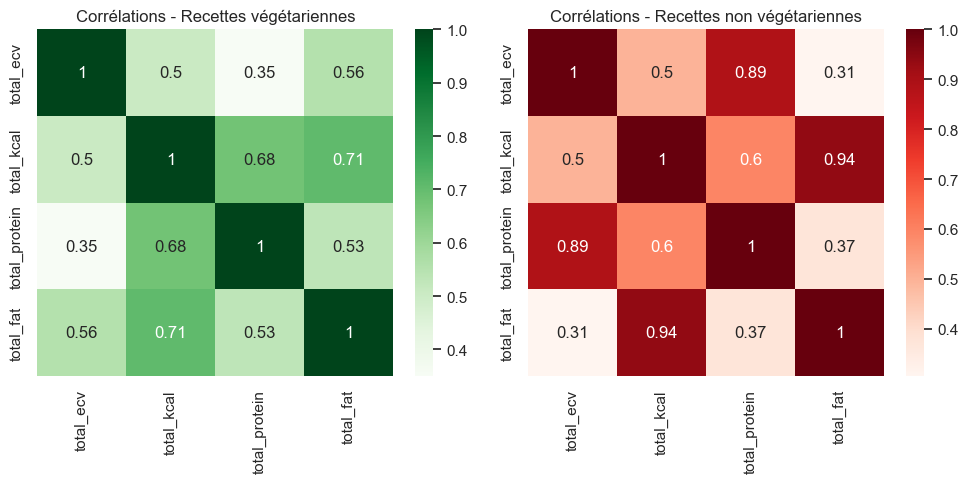

In [70]:
# Par type de recette
corr_vege = df[df['is_vege']==1][['total_ecv','total_kcal','total_protein','total_fat']].corr()
corr_nonvege = df[df['is_vege']==0][['total_ecv','total_kcal','total_protein','total_fat']].corr()

fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(corr_vege, annot=True, cmap="Greens", ax=axes[0])
sns.heatmap(corr_nonvege, annot=True, cmap="Reds", ax=axes[1])
axes[0].set_title("Corrélations - Recettes végétariennes")
axes[1].set_title("Corrélations - Recettes non végétariennes")
plt.tight_layout()
plt.show()

Scatterplots

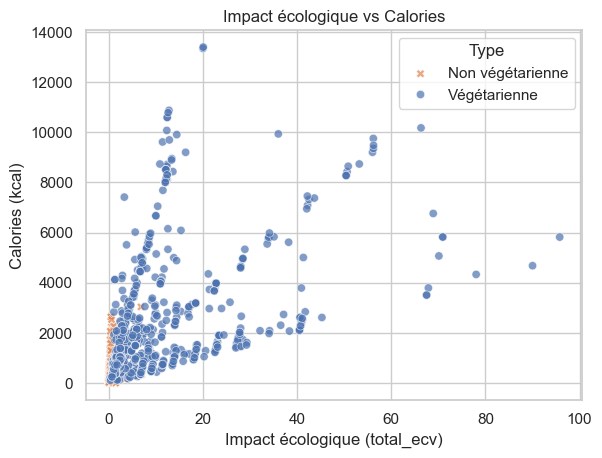

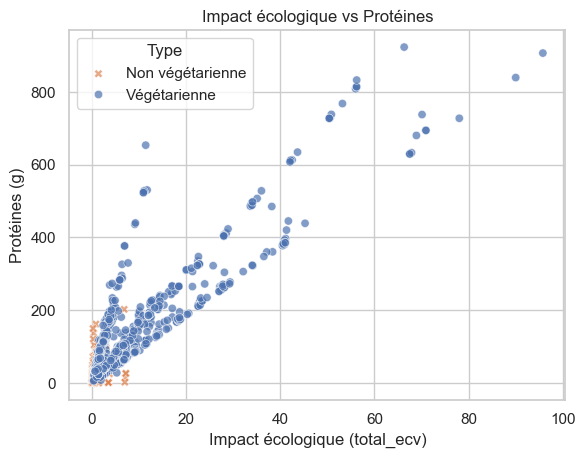

In [71]:
sns.scatterplot(data=df, x='total_ecv', y='total_kcal', hue='is_vege', style='is_vege', alpha=0.7)
plt.title("Impact écologique vs Calories")
plt.xlabel("Impact écologique (total_ecv)")
plt.ylabel("Calories (kcal)")
plt.legend(title="Type", labels=["Non végétarienne", "Végétarienne"])
plt.show()

sns.scatterplot(data=df, x='total_ecv', y='total_protein', hue='is_vege', style='is_vege', alpha=0.7)
plt.title("Impact écologique vs Protéines")
plt.xlabel("Impact écologique (total_ecv)")
plt.ylabel("Protéines (g)")
plt.legend(title="Type", labels=["Non végétarienne", "Végétarienne"])
plt.show()

La normalization ne change rien aux graphes

Recettes les plus et moins écologiques

In [72]:
print("Recettes les plus sobres écologiquement :")
display(df.nsmallest(8, 'total_ecv')[['title', 'total_ecv', 'total_kcal', 'total_protein', 'rating', "is_vege"]])

print("Recettes les plus impactantes écologiquement :")
display(df.nlargest(8, 'total_ecv')[['title', 'total_ecv', 'total_kcal', 'total_protein', 'rating', "is_vege"]])

df["score"] = df["total_protein"] - df["total_ecv"]
top_recipes = df.nlargest(8, "score")[["title","total_ecv", 'total_kcal', "total_protein","rating", "is_vege"]]
print("Recettes les plus optimales (riches en protéines, faibles en impact écologique) :")
display(top_recipes)

Recettes les plus sobres écologiquement :


,title,total_ecv,total_kcal,total_protein,rating,is_vege
140,Fajitas végétariennes aux haricots rouges,0.013862,13.300000,0.315000,3.8,1
374,Chili vegan aux poivrons,0.013862,13.300000,0.315000,0.0,1
386,Soupe façon Chinoise vegan,0.013862,13.300000,0.315000,0.0,1
199,TARTE AU CHOCOLAT ET AMANDES GRILLEES PAR ZAKO...,0.016902,21.362727,1.813909,0.0,1
645,"Sablé breton, crème légère vanille et rhubarbe...",0.016902,21.362727,1.813909,0.0,1
705,Mayonnaise légère à ma façon,0.016902,21.362727,1.813909,3.6,1
851,Mayonnaise légère au curry,0.016902,21.362727,1.813909,0.0,1
985,Millefeuille léger aux fraises et au mascarpone,0.016902,21.362727,1.813909,4.3,1


Recettes les plus impactantes écologiquement :


,title,total_ecv,total_kcal,total_protein,rating,is_vege
1443,"Osso-buco Milanaise, gremolata, spaghettis",95.785142,5821.316667,906.486389,5.0,0
1061,Ris de Veau aux champignons,90.018613,4680.000000,839.200000,4.8,0
1460,RIS de VEAU AUTHENTIQUE et RAPIDE,78.036720,4333.166667,727.415556,4.3,0
1034,Kebab capucin à l'effiloché d'agneau,70.944551,5823.918182,694.217727,0.0,0
1665,Kebab capucin à l'effiloché d'agneau,70.944551,5823.918182,694.217727,0.0,0
1958,Restes de poulet sauce fond de veau,70.124997,5069.565476,737.651984,0.0,0
1051,Rouelle de porc à l'ancienne,68.922851,6762.722222,680.233333,4.7,0
1191,Filet mignon de veau au cidre,67.892278,3793.658974,632.847466,4.8,0


Recettes les plus optimales (riches en protéines, faibles en impact écologique) :


,title,total_ecv,total_kcal,total_protein,rating,is_vege
1719,Boeuf bourguignon express,66.326332,10174.784416,922.948377,4.8,0
1443,"Osso-buco Milanaise, gremolata, spaghettis",95.785142,5821.316667,906.486389,5.0,0
1952,Chili burger (burger épicé),56.243701,9480.680519,832.419221,0.0,0
1081,Filet mignon de porc fondant en cocotte,56.196248,9754.710823,814.093766,4.6,0
1792,Daube provençale à l'ancienne,56.222673,9357.044156,813.913766,4.5,0
1079,Daube provençale,56.025271,9202.494156,808.391266,4.4,0
1061,Ris de Veau aux champignons,90.018613,4680.000000,839.200000,4.8,0
1597,"Rôti de boeuf au four, sauce aux champignons e...",53.217423,8736.051948,767.822078,4.9,0


## 3. Visualization - PCA

In [73]:
data = pd.read_json(RECIPES_FILE)
print("Number of rows (samples):", data.shape[0])
print("Number of variables:", data.shape[1])
display(data.head())
data.describe()

Number of rows (samples): 2089
Number of variables: 9


,title,url,rating,ingredients,total_ecv,total_kcal,total_protein,total_fat,is_vege
0,Lasagnes végétariennes (facile),https://www.marmiton.org/recettes/recette_lasa...,4.8,"[{'ingredient_name': 'tomates', 'quantity': 20...",0.449643,242.400000,15.760000,3.040000,1
1,Hachis parmentier végétarien,https://www.marmiton.org/recettes/recette_hach...,4.6,"[{'ingredient_name': 'poireau', 'quantity': 15...",0.269614,614.366667,6.910000,1.263333,1
2,Curry de légumes végétarien,https://www.marmiton.org/recettes/recette_curr...,4.8,"[{'ingredient_name': 'carotte', 'quantity': 40...",0.357829,224.000000,11.600000,2.400000,1
3,Hamburger Végétarien,https://www.marmiton.org/recettes/recette_hamb...,4.7,"[{'ingredient_name': 'oeuf', 'quantity': 60.0,...",0.112681,142.418182,12.092727,11.127273,1
4,Tourte de Noël végétarienne de Coralie,https://www.marmiton.org/recettes/recette_tour...,4.6,"[{'ingredient_name': 'beurre', 'quantity': 20....",0.270947,261.084848,13.534949,23.467273,1


,rating,total_ecv,total_kcal,total_protein,total_fat,is_vege
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,3.562087,4.642496,1307.109931,82.555216,87.370462,0.473911
std,1.827000,9.402856,1845.274577,114.354249,160.952798,0.499438
min,0.000000,0.013862,0.000000,0.000000,0.000000,0.000000
25%,3.300000,0.316533,298.136364,20.233056,14.480000,0.000000
50%,4.400000,1.368129,628.836364,41.333333,29.637273,0.000000
75%,4.800000,4.410986,1423.288889,100.902778,77.958333,1.000000
max,5.000000,95.785142,13396.533333,922.948377,1330.613333,1.000000


Scatter matrix of the pairwise features

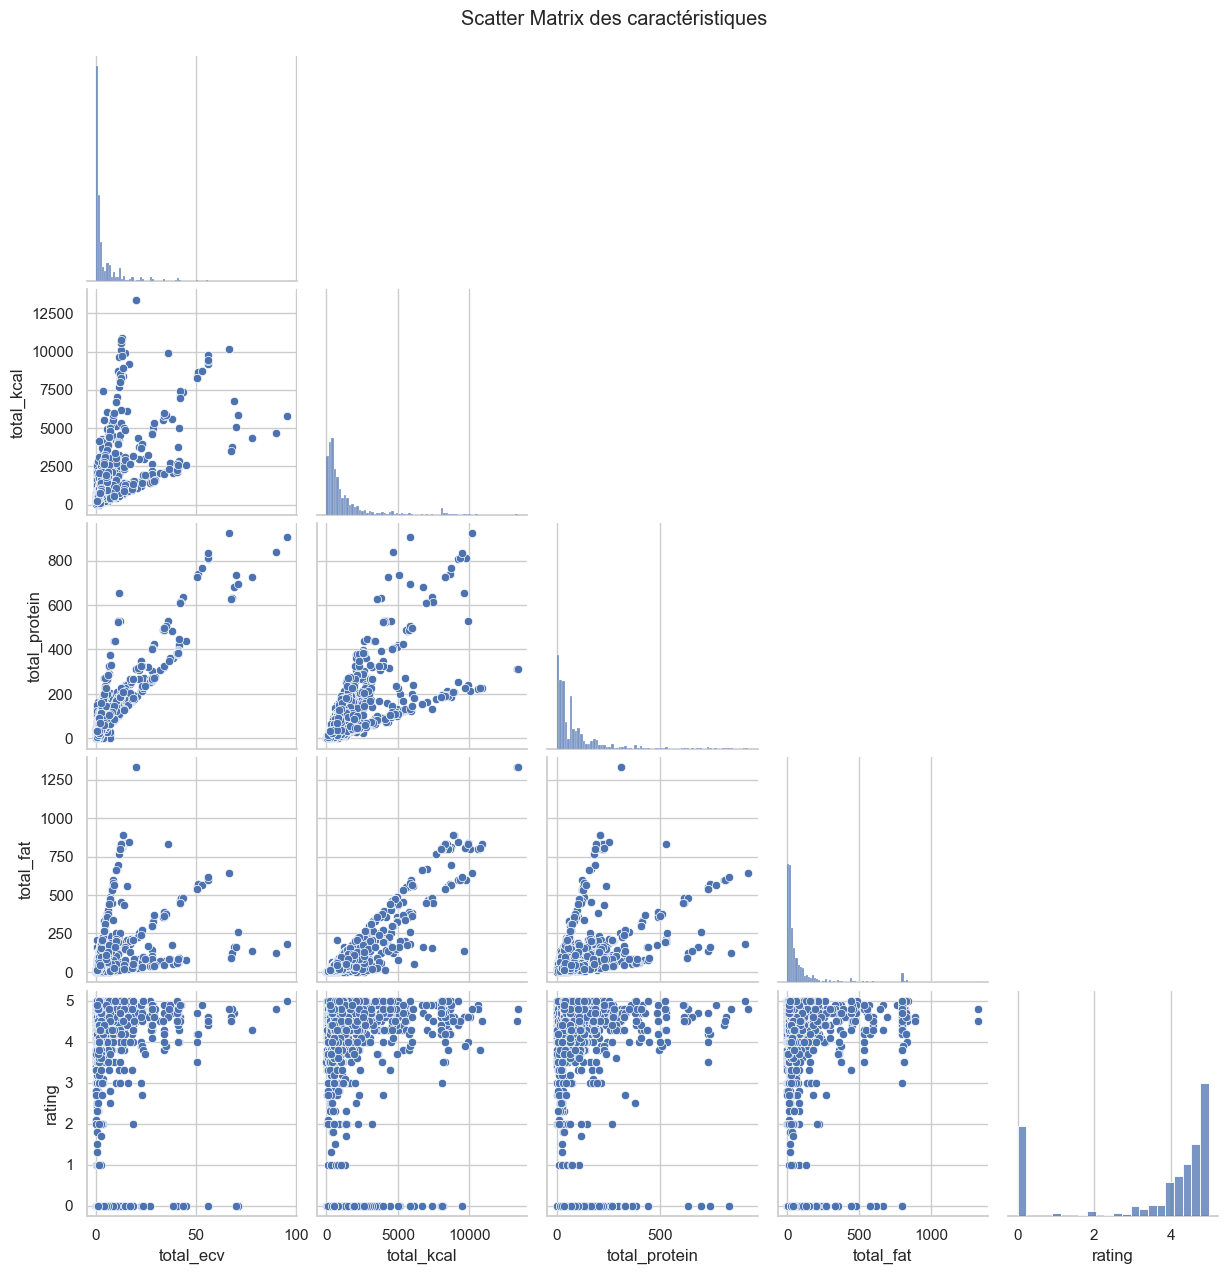

In [74]:
num_features = ["total_ecv", "total_kcal", "total_protein", "total_fat", "rating"]
sns.pairplot(data[num_features], corner=True)
plt.suptitle("Scatter Matrix des caractéristiques", y=1.02)
plt.show()

Violin plots

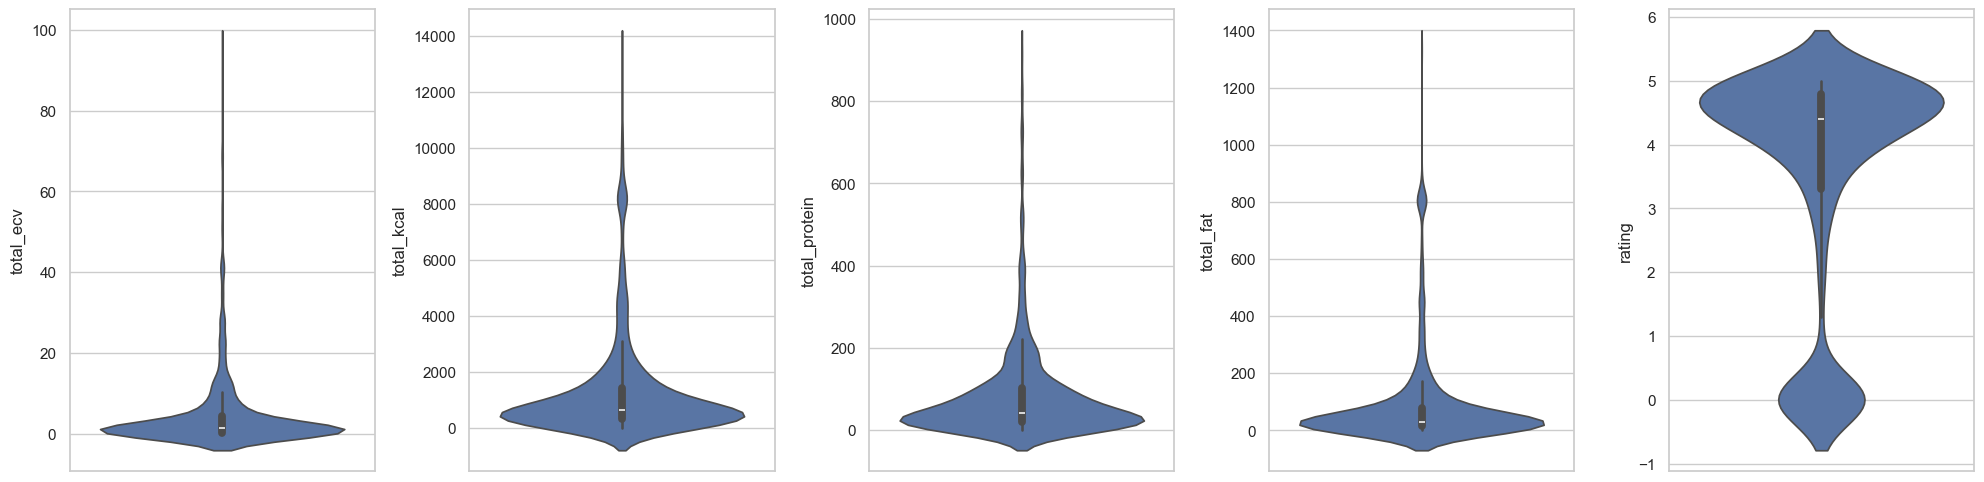

In [75]:
num_features = ["total_ecv", "total_kcal", "total_protein", "total_fat", "rating"]
n_features = len(num_features)


fig, axes = plt.subplots(1, n_features, figsize=(4*n_features, 5))  # 1 ligne, n colonnes
for i, col in enumerate(num_features):
    sns.violinplot(y=data[col], ax=axes[i])

plt.tight_layout()
plt.show()

PCA

In [76]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[num_features])

pca = PCA()
pca.fit(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Sum of explained variance ratio:", pca.explained_variance_ratio_.sum())

# Contribution of each feature to each component
loadings = pd.DataFrame(pca.components_, columns=num_features, index=[f"PC{i+1}" for i in range(len(num_features))])
display(loadings)

Explained variance ratio: [0.60449926 0.19595592 0.17424743 0.0195941  0.00570329]
Sum of explained variance ratio: 1.0000000000000002


,total_ecv,total_kcal,total_protein,total_fat,rating
PC1,0.478118,0.531661,0.509403,0.468038,0.100941
PC2,-0.069405,-0.053813,-0.035533,-0.043789,0.994539
PC3,-0.545205,0.377732,-0.438433,0.606468,-0.006571
PC4,0.678655,-0.177991,-0.672164,0.235293,0.024075
PC5,0.093624,0.734901,-0.308573,-0.596538,0.009008


Proportions of variances

,Explained Variance,Explained Variance Ratio,Cumulative Explained Variance
PC1,3.023944,0.604499,0.604499
PC2,0.980249,0.195956,0.800455
PC3,0.871654,0.174247,0.974703
PC4,0.098017,0.019594,0.994297
PC5,0.028530,0.005703,1.000000


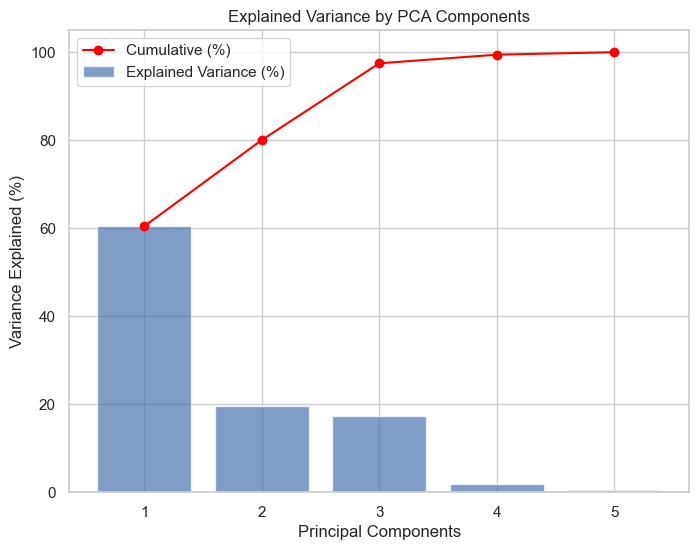

In [77]:
summary_table = pd.DataFrame({
    "Explained Variance": pca.explained_variance_,
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Explained Variance": np.cumsum(pca.explained_variance_ratio_)
}, index=[f"PC{i+1}" for i in range(len(num_features))])

display(summary_table)

explained_var_percent = pca.explained_variance_ratio_ * 100
cumulative_var_percent = np.cumsum(explained_var_percent)

plt.figure(figsize=(8,6))
plt.bar(range(1, len(explained_var_percent)+1), explained_var_percent, alpha=0.7, label='Explained Variance (%)')
plt.plot(range(1, len(cumulative_var_percent)+1), cumulative_var_percent, marker='o', color='red', label='Cumulative (%)')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# Keep the number of components explaining ≥ 90% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(X_scaled)

# Create DataFrame for transformed data
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_pca_df.head()

,PC1,PC2,PC3
0,-0.994580,0.779748,-0.040960
1,-0.952192,0.664564,0.073604
2,-1.024949,0.782430,-0.025862
3,-1.038875,0.729643,0.003014
4,-0.959835,0.666758,0.059470


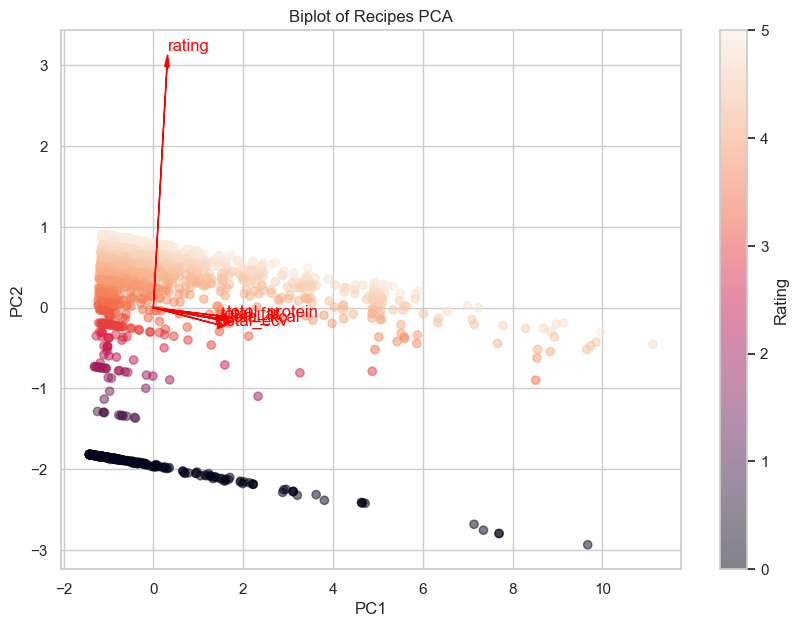

In [79]:
loadings = pca_2.components_.T  # composantes principales

plt.figure(figsize=(10,7))
plt.scatter(X_pca_2[:,0], X_pca_2[:,1], alpha=0.5, c=data['rating'])
plt.colorbar(label='Rating')

for i, feature in enumerate(num_features):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, color='red', alpha=1, head_width=0.1)
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, feature, color='red')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of Recipes PCA')
plt.grid(True)
plt.show()

## 4. Outlier detection

Version visuelle

/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/1759204210.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="is_vege", y=col,
/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/1759204210.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non végé", "Végétarienne"])
/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/1759204210.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="is_vege", y=col,
/var/folders/_s/9k_2p2tx05j9bqk_s8n_kw5m0000gn/T/ipykernel_7074/1759204210.py:13: UserWarning: set_ticklabels() should only b

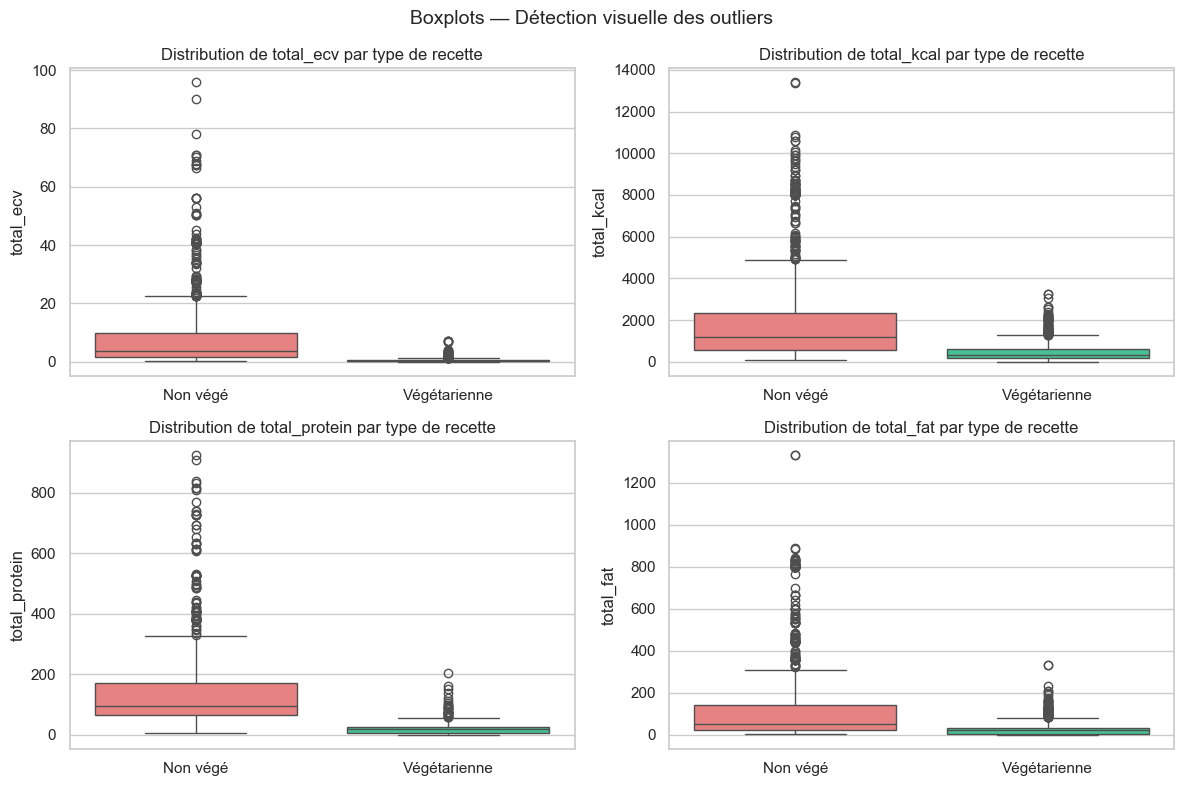

In [80]:
numeric_cols = ["total_ecv", "total_kcal", "total_protein", "total_fat"]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(numeric_cols):
    ax = axes[i//2, i%2]
    sns.boxplot(data=df, x="is_vege", y=col,
                palette=["#F87171", "#34D399"], ax=ax)
    ax.set_title(f"Distribution de {col} par type de recette")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.set_xticklabels(["Non végé", "Végétarienne"])

plt.suptitle("Boxplots — Détection visuelle des outliers", fontsize=14)
plt.tight_layout()
plt.show()

Version quantitative

In [81]:
outliers = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outliers[col] = n_outliers

outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Nombre d’outliers'])
display(outliers_df)

,Nombre d’outliers
total_ecv,265
total_kcal,214
total_protein,158
total_fat,251


Filtre des outliers pour travailler sur df_filtered 

In [82]:
df_filtered = df.copy()
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]

## 5. Biases

Data bias

* Données viennent de Marmiton, un site de cuisine français, donc non représentatif de toutes les cuisines végétariennes du monde.
* Les valeurs d’impact écologique (ecv) et nutritionnelles (kcal, protéines, lipides) proviennent d’une moyenne par ingrédient, sans tenir compte de l’origine, la saison, ni la méthode de production.
* Certaines recettes ont beaucoup d’ingrédients manquants (ou mal évalués), ce qui peut biaiser les moyennes et la PCA.

Model bias
* Le calcul des total_ecv, total_kcal, total_protein et total_fat suppose que les quantités sont comparables d’une recette à l’autre — ce n’est pas vrai si certaines portions sont énormes et d’autres petites.
* PCA suppose que les variables sont linéairement corrélées et centrées-réduites.
Or, ici, les écarts entre kcal, protéines et lipides sont énormes. Si on ne normalise pas, la PCA sera biaisée vers les variables à grande variance.

Interpretation bias
* Les données ne disent pas si les recettes sont réellement cuisinées ou populaires — une forte note (rating) ne garantit pas un faible impact réel.